In [38]:
import numpy as np
import pandas as pd
import xarray as xr
import xsimlab as xs
import episimlab as esl
from dask.diagnostics import ResourceProfiler

from episimlab.models import toy

In [2]:
!pip freeze | grep 'xarray-simlab\|episimlab'

-e git+https://github.com/eho-tacc/episimlab.git@558252eff1134626d637f447fa2c625375e26351#egg=episimlab
-e git+https://github.com/benbovy/xarray-simlab.git@84cabf69f5eb4cc872b496b2f1b04584a7e2b2bd#egg=xarray_simlab


This demo will use `xsimlab` v0.5.0 alpha (`84cabf69f5eb4cc872b496b2f1b04584a7e2b2bd`) and episimlab `558252eff1134626d637f447fa2c625375e26351`.

# 20201211_demo

The purpose of this notebook is to give a brief interactive overview of the `episimlab` package. It is recommended that the user obtain a basic knowledge of the `xarray-simlab` package before working through this tutorial. Work through the [Intro to xarray-simlab Jupyter notebook](./20201211_xsimlab_demo.ipynb) first, and refer to the resources linked below for more details.

For the most up-to-date documentation on `episimlab` and its dependencies, the reader is referred to the following resources:
* [Intro to xarray-simlab Jupyter notebook](./20201211_xsimlab_demo.ipynb)
* [`episimlab` GitHub](https://github.com/eho-tacc/episimlab)
* [`xarray-simlab` Read the Docs](https://xarray-simlab.readthedocs.io/en/latest/)
* [`xarray-simlab` GitHub](https://github.com/benbovy/xarray-simlab)
* [`xarray` Read the Docs](http://xarray.pydata.org/)

----

From the [README](../README.md):

> Episimlab is a framework for developing epidemiological models in a modular fashion. It provides a set of extensible, separable components that can be combined with user-written components, allowing for rapid development of reproducible disease-modeling pipelines.
> 
> * **Fully integrated with the [`xarray-simlab`](https://xarray-simlab.readthedocs.io/) package -** Episimlab provides a library of [`xsimlab.process` ]() classes ("processes"), as well as a handful of commonly-used [`xsimlab.model`]()s ("models").
> * **Extensible -** Users can quickly and easily develop their own process classes, either from scratch or based on an `episimlab` process, and include them in their models.
> * **Any variable can be high-dimensional -** Want constant `beta` for all time points? Use the `ConstantBeta` process. Want `beta` with age and risk group structure? Use `AgeRiskBeta`. Want to add your own custom structure and read it from a CSV file? Quickly write your own process, and it will integrate with processes provided by `episimlab`. Better yet, push your new process in a [Pull Request](CONTRIBUTING.md) so that others can use it!
> * **Good performance under the hood -** Frequently used processes - such as force of infection (FOI) calculation, SEIR disease progression, and travel between spatially separated nodes - are written in C-accelerated Python (Cython) with OpenMP support. This results in 100-1000X speed-up compared to the equivalent process written in pure Python.

In other words, `episimlab` is simply an organized collection of classes wrapped with the `xsimlab.process` decorator. It provides a domain-specific library of processes that interface just like the toy processes in [20201211_xsimlab_demo.ipynb](./20201211_xsimlab_demo.ipynb).

Although `episimlab` is mostly comprised of processes, it provides some pre-assembled default/toy models as a starting point. Let's inspect one of these models:

In [46]:
basic_seir = toy.cy_seir_cy_foi()
basic_seir

<xsimlab.Model (20 processes, 1 inputs)>
setup_coords
read_config
    config_fp     [in]
rng
sto
setup_counts
setup_beta
setup_eta
setup_gamma
setup_mu
setup_nu
setup_rho
setup_tau
setup_omega
setup_pi
setup_sigma
setup_phi_grp_mapping
setup_phi
foi
seir
apply_counts_delta

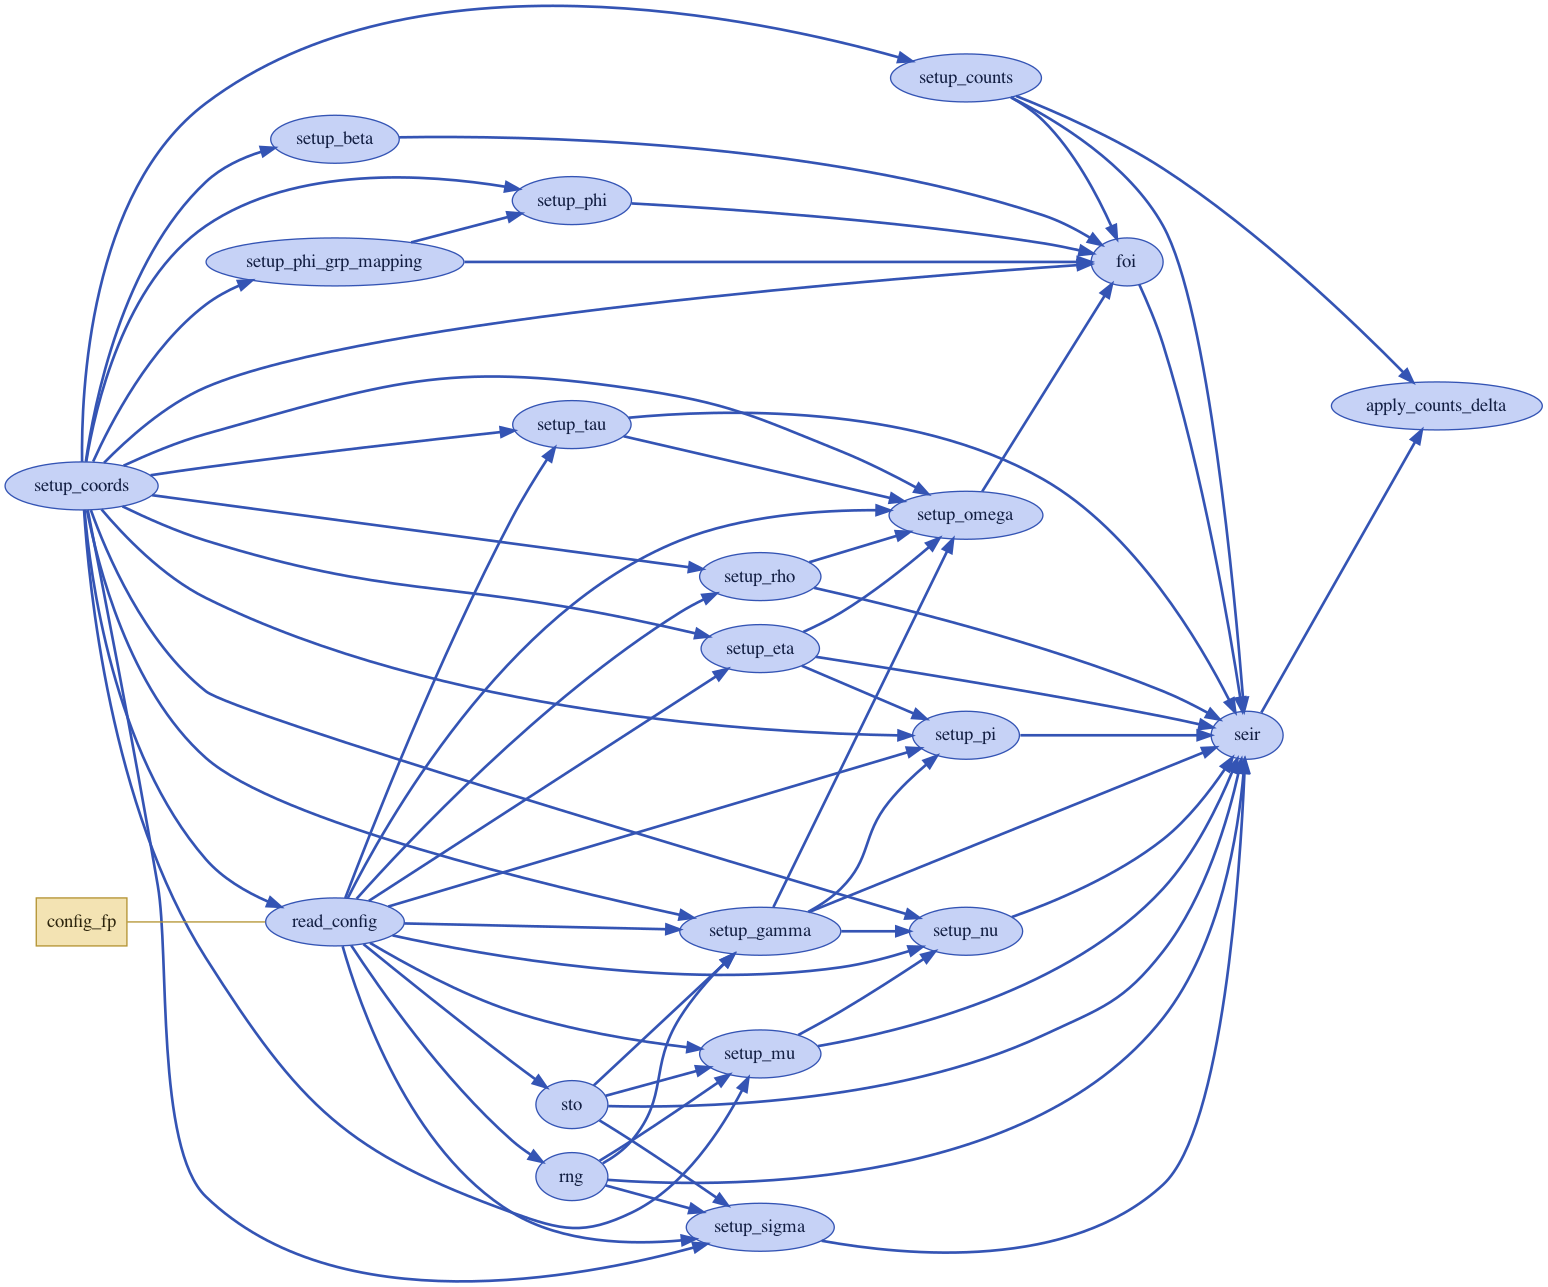

In [47]:
basic_seir.visualize(show_variables=False, show_inputs=True)

We can see that this is a large model in comparison to the toy ones in [20201211_xsimlab_demo.ipynb](./20201211_xsimlab_demo.ipynb). Despite the numerous processes, however, this model is running a simple epidemiology model comprised of a few key steps:

1. **Set up the parameters for the simulation -** All the processes named `setup_*` (and `read_config`) are responsible for pre-processing. Most of them help to generate the epidemiological variables named by letters of the Greek alphabet (sigma, nu, pi, etc.). Some of these processes - such as `setup_coords` and `setup_counts` - are responsible for setting up the number of geospatial vertices, number of age groups, initial population, and other arrays that must be instantiated before starting the simulation. Most of these processes only have an `initialize` stage.
2. **Simulate disease propagation -** As their names suggest, the `foi` and `seir` processess ingest the epidemiological params and simulate disease spread using an SEIR model. Specifically, the `seir` process calculates the change in population of each compartment (S, E, Pa, Py, I, R, etc.) for one step of the simulation. This calculation occurs at every simulation step. Most of the logic in these processes occurs in the `run_step` stage.
3. **`apply_counts_delta` -** This single, lightweight process is responsible for taking the change in compartment counts at each time step (generated by `seir` process), and adding that delta to the current population counts.

----

Let's run this model! It takes only one input variable: a path to a configuration YAML file located at `config_fp`. An example of this config file can be found at [../tests/config/example_v1.yaml](../tests/config/example_v1.yaml).

_WORK IN PROGRESS: descriptions of each variable in the config YAML_

Most of the variables in this config file are the same as SEIRcity v2. There are two especially important variables defined here, both relating to stochasticity:
1. **`sto_toggle` (int) -** The integer time step at which the simulation will switch from deterministic to stochastic. For instance, a value of zero runs the entire simulation stochastically. A value of 5 will run steps 0-4 deterministically, and every succeeding step stochastically. A value of -1 runs the simulation deterministically for all time steps.
2. **`seed_entropy` (int) -** An integer seed for the random number generator (RNG) used in stochastic simulation. Ignored if `sto_toggle < 0`. This simple yet important step occurs in the `finalize_step` phase.

We can run this model similar to how we ran toy models in [20201211_xsimlab_demo.ipynb](./20201211_xsimlab_demo.ipynb). Instead of the `range()` clock that we used previously, we use real dates for the clock by passing a Pandas DatetimeIndex. For this simulation, let's run two time points per day (`freq` kwarg).

In [21]:
step_clock = pd.date_range(
    start='2/1/2020',
    end='4/1/2020',
    freq='12H'
)
step_clock

DatetimeIndex(['2020-02-01 00:00:00', '2020-02-01 12:00:00',
               '2020-02-02 00:00:00', '2020-02-02 12:00:00',
               '2020-02-03 00:00:00', '2020-02-03 12:00:00',
               '2020-02-04 00:00:00', '2020-02-04 12:00:00',
               '2020-02-05 00:00:00', '2020-02-05 12:00:00',
               ...
               '2020-03-27 12:00:00', '2020-03-28 00:00:00',
               '2020-03-28 12:00:00', '2020-03-29 00:00:00',
               '2020-03-29 12:00:00', '2020-03-30 00:00:00',
               '2020-03-30 12:00:00', '2020-03-31 00:00:00',
               '2020-03-31 12:00:00', '2020-04-01 00:00:00'],
              dtype='datetime64[ns]', length=121, freq='12H')

In [48]:
# set up the simulation inputs, outputs, and clocks
in_ds = xs.create_setup(
    model=basic_seir,
    clocks={
        'step': step_clock
    },
    input_vars={
        'read_config__config_fp': '../tests/config/example_v1.yaml'
    },
    output_vars={
        'apply_counts_delta__counts': 'step'
    }
)
in_ds

<xarray.Dataset>
Dimensions:                 (step: 121)
Coordinates:
  * step                    (step) datetime64[ns] 2020-02-01 ... 2020-04-01
Data variables:
    read_config__config_fp  <U31 '../tests/config/example_v1.yaml'

**NOTE:** To work around a fill value bug in `xsimlab` v0.5.0 alpha, one must pass `decoding` kwarg to `run`. See the [GitHub issue](https://github.com/benbovy/xarray-simlab/issues/162) for details.

In [49]:
# run the model
# ...with a profiling tool from Dask
with ResourceProfiler(dt=1.) as rprof:
    out_ds = in_ds.xsimlab.run(
        model=basic_seir,
        decoding=dict(mask_and_scale=False)
    )

Dask provides a nice plot of memory and CPU usage:

In [50]:
rprof.visualize(save=False, show=True)

Figure(id='1520', ...)

In [51]:
out_ds

<xarray.Dataset>
Dimensions:                     (age_group: 5, compartment: 16, day_of_week: 7, phi_grp1: 10, phi_grp2: 10, risk_group: 2, step: 121, vertex: 3)
Coordinates:
  * age_group                   (age_group) <U5 '0-4' '5-17' ... '50-64' '65+'
  * compartment                 (compartment) <U5 'S' 'E' 'Pa' ... 'Iy2Ih' 'H2D'
  * day_of_week                 (day_of_week) int64 0 1 2 3 4 5 6
  * phi_grp1                    (phi_grp1) int64 1 0 5 4 3 2 7 6 9 8
  * phi_grp2                    (phi_grp2) int64 1 0 5 4 3 2 7 6 9 8
  * risk_group                  (risk_group) <U4 'low' 'high'
  * step                        (step) datetime64[ns] 2020-02-01 ... 2020-04-01
  * vertex                      (vertex) int64 0 1 2
Data variables:
    apply_counts_delta__counts  (step, vertex, age_group, risk_group, compartment) float64 ...
    read_config__config_fp      <U31 '../tests/config/example_v1.yaml'

In [71]:
out_ds['apply_counts_delta__counts'][dict(step=2)].loc[dict(compartment='Ia')]

<xarray.DataArray 'apply_counts_delta__counts' (vertex: 3, age_group: 5, risk_group: 2)>
array([[[ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ]],

       [[37.5, 37.5],
        [37.5, 37.5],
        [37.5, 37.5],
        [37.5, 37.5],
        [37.5, 37.5]],

       [[ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ]]])
Coordinates:
  * age_group    (age_group) <U5 '0-4' '5-17' '18-49' '50-64' '65+'
    compartment  <U5 'Ia'
  * risk_group   (risk_group) <U4 'low' 'high'
    step         datetime64[ns] 2020-02-02
  * vertex       (vertex) int64 0 1 2
Attributes:
    _FillValue:  nan

In [56]:
def xr_viz(data_array, sel=dict(), isel=dict(),
           timeslice=slice(0, None),
           sum_over=['risk_group', 'age_group']):
    """Uses DataArray.plot, which builds on mpl
    """
    assert isinstance(data_array, xr.DataArray)
    isel.update({'step': timeslice})
    da = data_array[isel].loc[sel].sum(dim=sum_over)
    _ = da.plot.line(x='step', aspect=2, size=7)

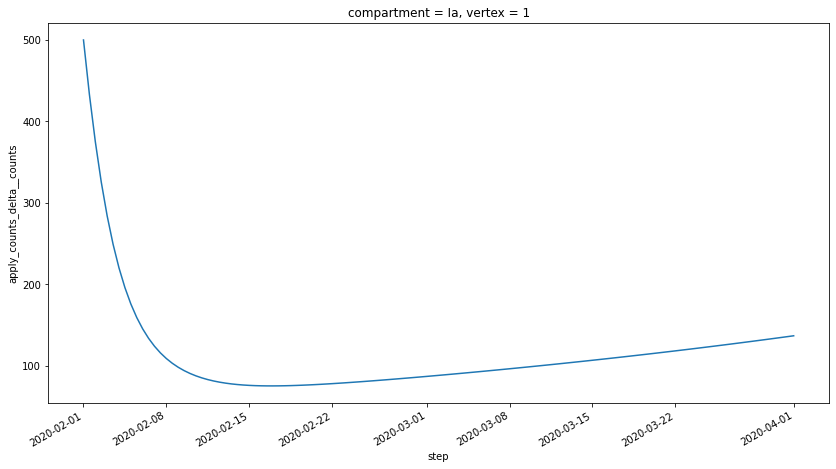

In [73]:
xr_viz(out_ds['apply_counts_delta__counts'], sel=dict(vertex=1, compartment='Ia'))

This should take a few seconds on a laptop (thanks to C-accelerated, AKA Cython, SEIR model!).

This default model provides a majority of the groundwork required to run a basic SEIR model. However, it has several characteristics that one would usually like to change from the default:
* Number of geospatially separated vertices: 3 by default
* No travel between nodes